In [107]:
## Imports

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing ## regression dataset
from sklearn.datasets import load_wine ## classification dataset

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import r2_score


# **Algorithm: Build a decision tree from scratch**

In [108]:
## Algorithm to build decision tree from scratch

class DecisionTree:
    def __init__(self, depth=0, max_depth=None, min_samples_split=2,min_samples_leaf=1,task='classification'):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_leaf=min_samples_leaf
        self.min_samples_split = min_samples_split
        self.task = task
        self.feature_index = None
        self.split_threshold = None
        self.left_child = None
        self.right_child = None
        self.label = None
        self.n_leaves = 0
        
    def fit(self, X, y):
        X = np.array(X) 
        y = np.array(y) 
        n_samples, n_features = X.shape
        best_gain = -np.inf
        
         # task identification & check if we need to stop splitting
    
        if self.task == 'classification':
            n_labels = len(np.unique(y))
            # leaf node
            if (n_samples < self.min_samples_split) or (self.depth == self.max_depth) or (n_labels == 1):
                self.label = self._most_common_label(y)
                print("Leaf Node: Depth={}, Samples={}, Class={}, Gini Impurity={:.2f}".format(self.depth, len(y), self.label, self._gini(y)))
                return

        else: # regression task
            n_labels = 1 
            # leaf node
            if (n_samples < self.min_samples_split) or (self.depth == self.max_depth):
                self.label = np.mean(y) 
                print("Leaf Node: Depth={}, Samples={}, Value={:.2f}, MSE={:.2f}".format(self.depth, len(y), self.label,self._mse(y)))
                return
       
        
        # loop over all features to find the best split
        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])
            for threshold in unique_values:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold
                
                if (len(y[left_indices]) < 1) or (len(y[right_indices]) < 1):
                    continue
                    
                if self.task == 'classification':
                    gain = self._gini_gain(y, left_indices, right_indices)
                else:
                    gain = self._mse_gain(y, left_indices, right_indices)
                
                if gain > best_gain:
                    best_gain = gain
                    self.feature_index = feature
                    self.split_threshold = threshold
                
        
        # split the data and recursively build subtrees
        left_indices = X[:, self.feature_index] <= self.split_threshold
        right_indices = X[:, self.feature_index] > self.split_threshold
        
        self.left_child = DecisionTree(depth=self.depth+1, max_depth=self.max_depth, min_samples_split=self.min_samples_split, task=self.task)
        self.left_child.fit(X[left_indices], y[left_indices])
        
        self.right_child = DecisionTree(depth=self.depth+1, max_depth=self.max_depth, min_samples_split=self.min_samples_split, task=self.task)
        self.right_child.fit(X[right_indices], y[right_indices])
    
        ### Characteristics of splitting node
        if self.task == 'classification':
          print("Splitting Node: Depth={}, Samples={}, Feature={}, Threshold={}, Gain={:.2f}, Gini Impurity={:.2f}".\
                format(self.depth, len(y), self.feature_index, self.split_threshold, best_gain, self._gini(y)))
          
        else:
          print("Splitting Node: Depth={}, Samples={}, Feature={}, Threshold={}, Gain={:.2f}, MSE={:.2f}".\
                format(self.depth, len(y), self.feature_index, self.split_threshold, best_gain, self._mse(y)))
        

    # assign a class to leaf node (classification task) 
    def _most_common_label(self, y):
        labels, counts = np.unique(y, return_counts=True)
        return labels[np.argmax(counts)]
    

    # choose best split in classification task
    def _gini_gain(self, y, left_indices, right_indices):
        p = len(y[left_indices]) / (len(y[left_indices]) + len(y[right_indices]))
        return self._gini(y) - p * self._gini(y[left_indices]) - (1-p) * self._gini(y[right_indices])
    
    def _gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1 - np.sum(p**2)

    # choose best split in regression task
    def _mse_gain(self, y, left_indices, right_indices):
        return self._mse(y) - len(y[left_indices])/len(y) * self._mse(y[left_indices]) - len(y[right_indices])/len(y) * self._mse(y[right_indices])
    
    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)


    # number of leaves in the tree
    def count_leaves(self):
        if self.left_child is None and self.right_child is None:
            return 1
        else:
            return self.left_child.count_leaves() + self.right_child.count_leaves()


    # predict values of test set  
    def predict(self,X):
        if self.label is not None:
            return self.label
        elif X[self.feature_index] <= self.split_threshold: 
            return self.left_child.predict(X)
        else:
            return self.right_child.predict(X)

# **Classification task**

In [109]:
# Load wine dataset
wine = load_wine(as_frame = True)
df = pd.concat([wine.data, wine.target], axis=1)
print ('number of rows in the dataset:',len(df))
df.head()

number of rows in the dataset: 178


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [110]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2)

In [111]:
# Application of our algorithm for classification task

## Create object and choose parameters
tree = DecisionTree(max_depth=10, min_samples_split=4) 

## Construction of tree from training data and display nodes characteristics
tree.fit(X_train, y_train) 

## Use 'count_leaves' method to print the number of leaves in the tree
print('\n Number of leaves in the tree:', tree.count_leaves())

Leaf Node: Depth=3, Samples=4, Class=1, Gini Impurity=0.00
Leaf Node: Depth=4, Samples=28, Class=2, Gini Impurity=0.00
Leaf Node: Depth=4, Samples=1, Class=1, Gini Impurity=0.00
Splitting Node: Depth=3, Samples=29, Feature=6, Threshold=1.57, Gain=0.07, Gini Impurity=0.07
Splitting Node: Depth=2, Samples=33, Feature=3, Threshold=16.8, Gain=0.20, Gini Impurity=0.26
Leaf Node: Depth=3, Samples=1, Class=2, Gini Impurity=0.00
Leaf Node: Depth=4, Samples=46, Class=1, Gini Impurity=0.00
Leaf Node: Depth=5, Samples=1, Class=0, Gini Impurity=0.00
Leaf Node: Depth=5, Samples=3, Class=1, Gini Impurity=0.00
Splitting Node: Depth=4, Samples=4, Feature=0, Threshold=13.24, Gain=0.38, Gini Impurity=0.38
Splitting Node: Depth=3, Samples=50, Feature=0, Threshold=13.11, Gain=0.01, Gini Impurity=0.04
Splitting Node: Depth=2, Samples=51, Feature=6, Threshold=0.5, Gain=0.04, Gini Impurity=0.08
Splitting Node: Depth=1, Samples=84, Feature=11, Threshold=2.15, Gain=0.32, Gini Impurity=0.47
Leaf Node: Depth=3, 

In [112]:
## Predictions on test set using the 'predict' method
y_pred = np.array([tree.predict(x) for x in X_test.values])

In [113]:
## Comparison between predicted and true values

# Predicted values
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted  with DT from scratch: ",)
print("Number of 0s:", counts[0])
print("Number of 1s:", counts[1])
print("Number of 2s:", counts[2], '\n')

# True values of test set
unique, counts = np.unique(y_test, return_counts=True)
print("True values with DT from scratch:",)
print("Number of 0s:", counts[0])
print("Number of 1s:", counts[1])
print("Number of 2s:", counts[2])


Predicted  with DT from scratch: 
Number of 0s: 10
Number of 1s: 12
Number of 2s: 14 

True values with DT from scratch:
Number of 0s: 10
Number of 1s: 13
Number of 2s: 13


In [114]:
### Metrics for classification to evaluate quality of our tree

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision : ",precision)
print("Recall : ", recall)
print("F1_score : " ,f1)

Accuracy: 0.9722222222222222
Precision :  0.9742063492063492
Recall :  0.9722222222222222
F1_score :  0.9721810699588479


 **Comparison with Python Implementation using DecisionTreeClassifier()**


In [115]:
# Imports 
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

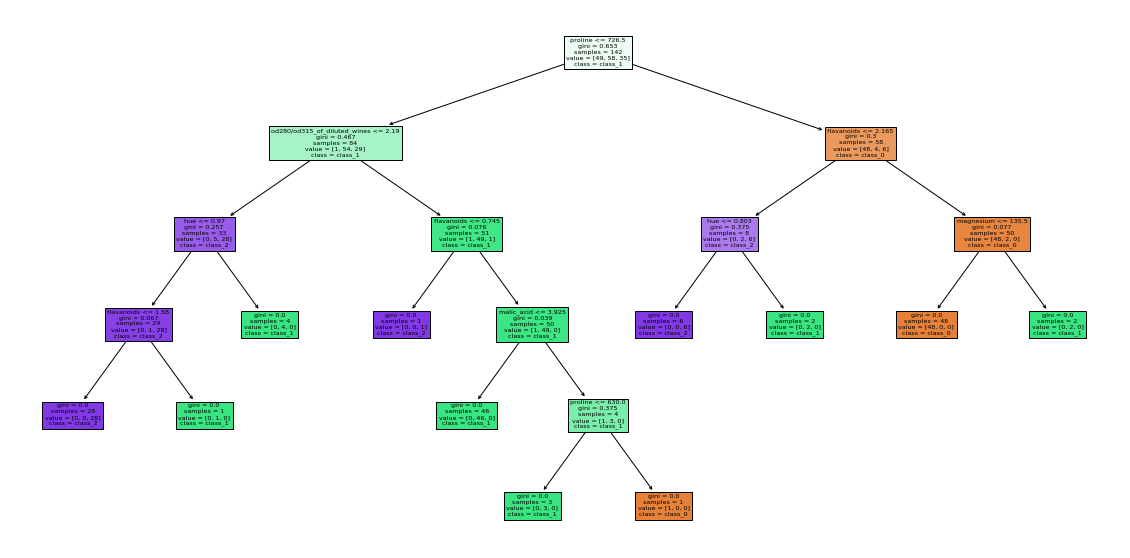

In [116]:
#### Creation of tree object
clf = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 1,  min_samples_split = 4)

# Fit with train data
clf = clf.fit(X_train,y_train)

# Plot the tree obtained with training data
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=wine.feature_names, class_names=wine.target_names, filled=True)
plt.show()

In [117]:
# Predict the classes for test dataset
y_pred = clf.predict(X_test)

In [119]:
# Metrics to evaluate quality of Python decision tree
acc_score = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", acc_score)
print("precision: ",precision)
print("recall: ", recall)
print("F1_score: " ,f1)

Accuracy: 0.9444444444444444
precision:  0.9518518518518518
recall:  0.9444444444444444
F1_score:  0.9441137566137565


On this example, our algorithm performs better than Python implementation for classification task, as it shows higher values for metrics.

### **Regression task**

In [120]:
# Load the regression dataset

california = fetch_california_housing(as_frame=True)
print('number of rows:',(len(california.data)))

number of rows: 20640


In [121]:
### Keep only 2000 rows so that the computional cost of the algorithm do not become too high

california.data = california.data.head(2000)
california.target = california.target.head(2000)
df = pd.concat([california.data, california.target], axis=1)
df.head()
print('New number of rows:',(len(california.data)))

New number of rows: 2000


In [122]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(california.data, california.target, test_size=0.2)


In [123]:
## Using our algorithm, construction of decision tree for regression task

# Create the object and choose the parameters
tree = DecisionTree(max_depth=4,min_samples_split=10,min_samples_leaf=5, task='regression')

# Build the regression tree and display nodes characteristics
tree.fit(X_train, y_train) 

# Display number of leaves with our method
print('\n number of leaves in the tree:', tree.count_leaves())

Leaf Node: Depth=4, Samples=99, Value=1.96, MSE=0.39
Leaf Node: Depth=4, Samples=27, Value=1.15, MSE=0.17
Splitting Node: Depth=3, Samples=126, Feature=6, Threshold=37.94, Gain=0.11, MSE=0.45
Leaf Node: Depth=4, Samples=405, Value=1.27, MSE=0.28
Leaf Node: Depth=4, Samples=123, Value=0.84, MSE=0.07
Splitting Node: Depth=3, Samples=528, Feature=6, Threshold=38.94, Gain=0.03, MSE=0.27
Splitting Node: Depth=2, Samples=654, Feature=5, Threshold=2.160919540229885, Gain=0.06, MSE=0.36
Leaf Node: Depth=4, Samples=158, Value=2.39, MSE=0.34
Leaf Node: Depth=4, Samples=214, Value=1.98, MSE=0.19
Splitting Node: Depth=3, Samples=372, Feature=5, Threshold=2.464071856287425, Gain=0.04, MSE=0.30
Leaf Node: Depth=4, Samples=103, Value=1.36, MSE=0.09
Leaf Node: Depth=4, Samples=124, Value=1.75, MSE=0.19
Splitting Node: Depth=3, Samples=227, Feature=0, Threshold=3.9519, Gain=0.04, MSE=0.18
Splitting Node: Depth=2, Samples=599, Feature=6, Threshold=37.94, Gain=0.08, MSE=0.33
Splitting Node: Depth=1, Samp

In [124]:
# Predictions on test dataset
y_pred = np.array([tree.predict(x) for x in X_test.values])

In [125]:
## Comparison between predicted and true values
print('Descriptive analysis predicted values: \n',(pd.DataFrame(y_pred, columns = ['Price'])).describe(),'\n')
print('Descriptive analysis true values: \n', y_test.describe())

Descriptive analysis predicted values: 
             Price
count  400.000000
mean     1.861139
std      0.781847
min      0.837325
25%      1.268647
50%      1.853808
75%      2.394785
max      4.623260 

Descriptive analysis true values: 
 count    400.000000
mean       1.832880
std        0.907002
min        0.225000
25%        1.127250
50%        1.667500
75%        2.300500
max        5.000010
Name: MedHouseVal, dtype: float64


In [126]:
# Metrics for regression to evaluate quality of our decision tree
mse = np.mean((y_test - y_pred)**2)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2=r2_score(y_test, y_pred)

print("MSE: ", mse) ### mse ??
print(f"RMSE: {rmse:.3f}")
print('R2 :',r2)

MSE:  0.2915210774292119
RMSE: 0.540
R2 : 0.6447450532993002


**Comparison with Python implementation of decision tree regressor**

In [128]:
 #Create a decision tree regressor and fit it to the training data
tree = DecisionTreeRegressor(max_depth=4, min_samples_split=10,  min_samples_leaf = 5,random_state=42)
tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=10,
                      random_state=42)

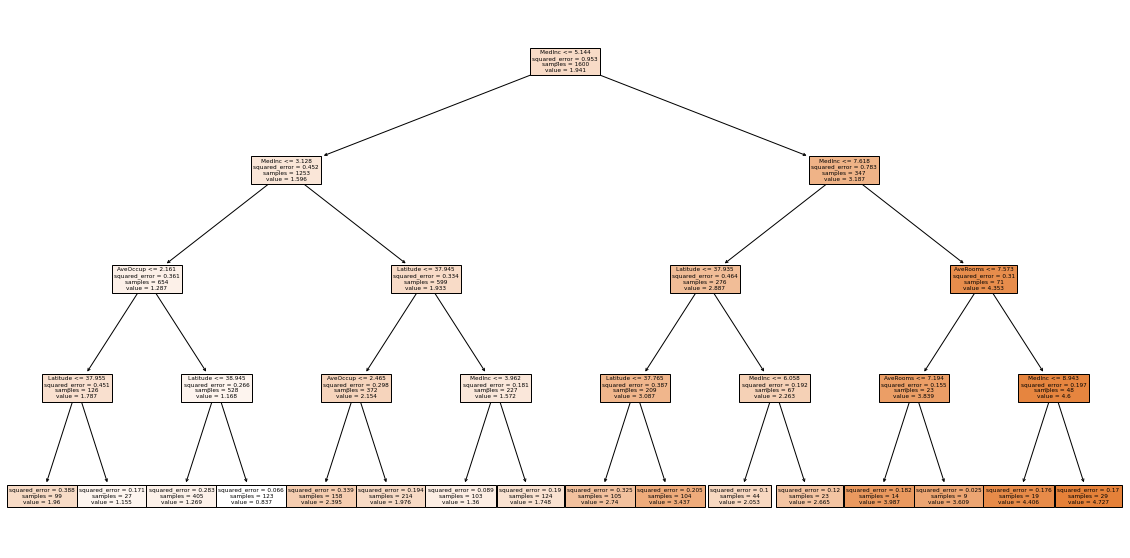

In [129]:
### Plot the tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=california.feature_names, class_names=california.target_names, filled=True)
plt.show()

In [130]:
# Predictions on test dataset
y_pred = tree.predict(X_test)

In [131]:
## Metrics to evaluate quality of python decision tree
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)

print("MSE: ", mse)
print(f"RMSE: {rmse:.3f}")
print('R2 :',r2)

MSE:  0.28769721648048086
RMSE: 0.536
R2 : 0.6494049068149081


Our algorithm performs as good as Python implementation for classification (R2 of 64%)